# Data-driven course term project

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats
import scipy.signal
import math
import warnings
warnings.filterwarnings('ignore')

## Data cleaning

The first step is to select the sampling time period when most measurements can overlap. Then we align different measurements by integrating linearly across time-series. Categorical variables (hour, dow, month, year) are coded as dummy varibles.

In [ ]:
'''Read from metadata.csv and create variable mapping''' 
metaPath = '/Volumes/0310/TP-Data/metadata.csv'
meta = pd.read_csv(metaPath)
varMap = [meta['variable'][var] for var in range(len(meta))]

In [ ]:
'''
findTimeSpan() reads from one csv data file and gets the NA percentage, 
returns the mean/max time gap, the start/end of sampling period
'''
def findTimeSpan(file_id, threshold):
    tagFile = '/Volumes/0310/TP-Data/data/'+str(file_id)+'.csv'
    file = pd.read_csv(tagFile)
    file.columns = file.columns.str.strip()    
    file['value'] = pd.to_numeric(file['value'],'coerce')
    NACounts = file['value'].isnull().value_counts()[True]
    if NACounts >= threshold*len(file):
        return (None,None,None,None)
    file['timeStamp'] = pd.to_datetime(file['timeStamp'],format = '%H:%M:%S %m-%d-%Y')
#    file.sort_values(by=['timeStamp'])
    file['Hour'] = file['timeStamp'].dt.hour
    file['Date'] = file['timeStamp'].dt.hour
    file['DayOfWeek'] = file['timeStamp'].dt.dayofweek
    diff = np.diff(file['timeStamp'])
    gap = np.max(diff/10**9/3600)
    meanGap = np.mean(diff/10**9/3600)
    timeSpanStart = file['timeStamp'][0]
    timeSpanEnd = file['timeStamp'][len(file)-1]
    return(gap,meanGap,timeSpanStart,timeSpanEnd)

In [ ]:
'''
downSample() cleans the irregularities in the values, makes tags with NA
more than threshold NA, downsamples the sampling frequency to 1 pt/hour,
and aligns all tags
'''
def downSample(file_id,date_start,date_end,threshold):
    tagFile = '/Volumes/0310/TP-Data/data/'+str(file_id)+'.csv'
    file = pd.read_csv(tagFile)
    file.columns = file.columns.str.strip()    
    file['value'] = pd.to_numeric(file['value'],'coerce')
    NACounts = file['value'].isnull().value_counts()[True]
    if NACounts >= threshold*len(file):
        return (False,file) 
    file['timeStamp'] = pd.to_datetime(file['timeStamp'],format = '%H:%M:%S %m-%d-%Y')
    filterDate = (file['timeStamp'] > date_start) & (file['timeStamp'] < date_end)
    file = file[filterDate]
    file.iloc[0,0] = datetime.datetime.strptime('00:00:00 '+date_start,'%H:%M:%S %m-%d-%Y')
    file.iloc[len(file)-1,0] = datetime.datetime.strptime('23:00:00 '+ date_end,'%H:%M:%S %m-%d-%Y')
    file = file.set_index(file['timeStamp'])
    file = file.resample('H').mean().interpolate(method='linear')
    return (True,file)

In [ ]:
for file_id in range(len(varMap)):
    (gap,meanGap,timeSpanStart,timeSpanEnd) = findTimeSpan(file_id,0.5)
    if gap != None:
        print(file_id,gap,meanGap,timeSpanStart,timeSpanEnd)

In [31]:
# Selected dates based on the results above
date_start = '02-14-2015' #00:00:00
date_end   = '01-06-2016' #23:00:00
# This is a regular measurement selected for getting timestamps
file_id = 363
(flag,dataset) = downSample(file_id,date_start,date_end,0.5)
ts = dataset.index
dataset = pd.DataFrame(np.zeros((len(ts), len(varMap)+1)),columns=['timeStamp']+varMap)
dataset.iloc[:,0] = ts
for file_id in range(len(varMap)):
    tag = varMap[file_id]
    (flag,file) = downSample(file_id,date_start,date_end,0.5)
    if flag == False:
        dataset.iloc[:,file_id+1] = pd.np.nan
    else:
        dataset.iloc[:,file_id+1] = list(file['value'])
    print(file_id)
# Remove NA columns (i.e. vars with >threhold NA)
dataset = dataset.dropna(axis=1, how='all')
dataset['Hour']      = dataset['timeStamp'].dt.hour
dataset['Dayofweek'] = dataset['timeStamp'].dt.dayofweek
dataset['Month']     = dataset['timeStamp'].dt.month
dataset['Year']      = dataset['timeStamp'].dt.year

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'Series' object has no attribute 'hour'

In [33]:
dataset.to_csv('./dataset-no-dummies.csv',index=False)

In [34]:
'''Dummy variable for categorical variables'''
dowDummy = pd.get_dummies(dataset['Dayofweek'],prefix='dow_')
hDummy   = pd.get_dummies(dataset['Hour'],prefix = 'hour_')
mDummy   = pd.get_dummies(dataset['Month'],prefix = 'mon_')
yDummy   = pd.get_dummies(dataset['Year'],prefix = 'hour_')
tmp      = np.hstack((np.array(dataset),
                      np.array(dowDummy),
                      np.array(hDummy),
                      np.array(mDummy),
                      np.array(yDummy)))
columns = np.hstack((dataset.columns,
                     dowDummy.columns,
                     hDummy.columns,
                     mDummy.columns,
                     yDummy.columns))
dataset_dummies = pd.DataFrame(tmp[:,1:],columns=columns[1:])
dataset_dummies['timeStamp'] = dataset['timeStamp']
dataset_dummies.to_csv('./dataset-dummies.csv',index=False)

## Exploratory analysis (START FROM HERE)

In [5]:
dataset_dummies = pd.read_csv('./dataset-dummies (1).csv')

### Cleaning and normalization

In [6]:
dat       = dataset_dummies.iloc[:,1:dataset_dummies.shape[1]-1]
#dat.index = dataset_dummies['timeStamp']
dat       = dat.astype('float')
Y = dat.iloc[:,-67:-49]
# Demand, can change
y = Y.iloc[:,5]
X = dat.drop(dat.columns[range(-67,-49)],axis=1)

# Variance Threshold
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
sel = sel.fit(X)
X = X.T[sel.get_support()].T

# Drop extra dow,month,year
X = X.drop(dat.columns[range(-49,-45)],axis=1)
dummies    = np.array(X.iloc[:,-45:])
nondummies = X.drop(X.columns[range(-45,0)],axis=1)
columns    = X.columns
nondummies = scipy.stats.zscore(nondummies)
X  = pd.DataFrame(np.hstack((nondummies,dummies)),
                  columns = columns)

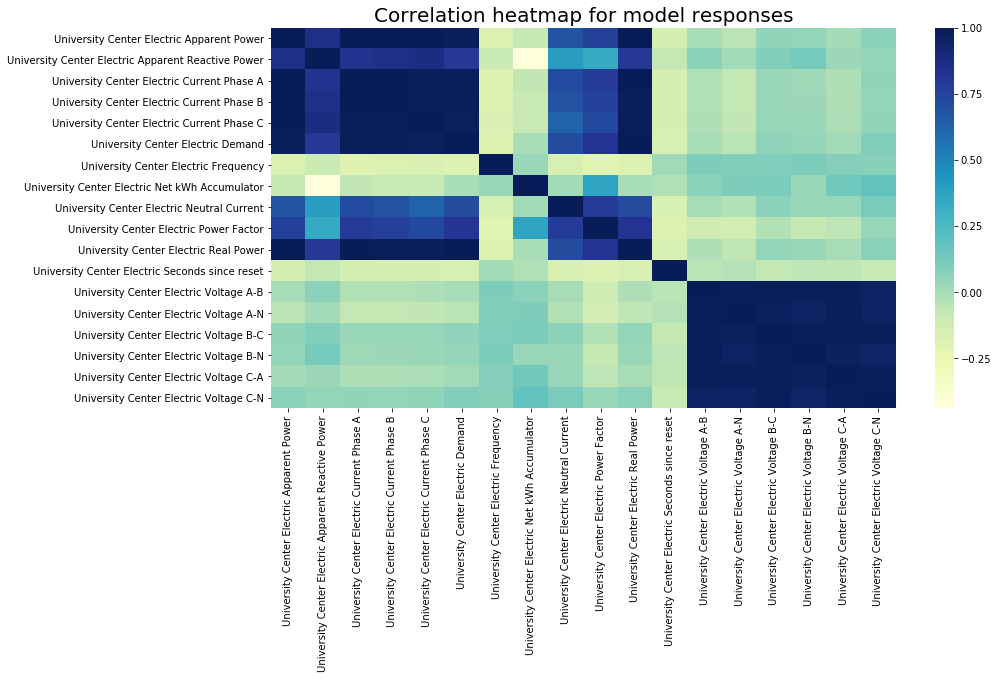

In [7]:
# Correlation heatmap for Y
fig = plt.figure(figsize=(14,7))
plt.title('Correlation heatmap for model responses',size=20)
sns.heatmap(Y.corr(),cmap="YlGnBu")

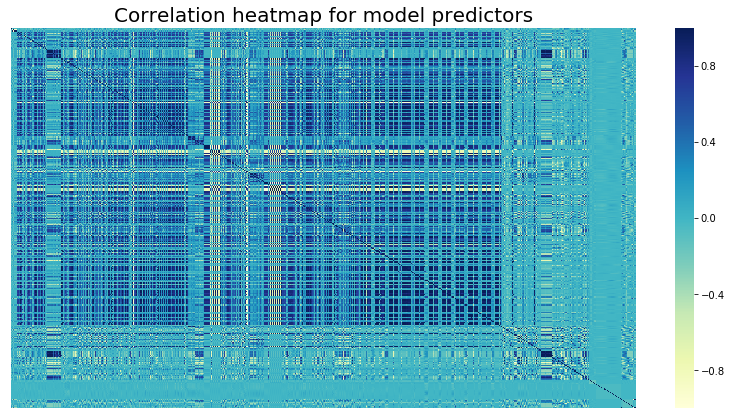

In [8]:
# Correlation heatmap for X
'''Most variables are correlated'''
fig = plt.figure(figsize=(14,7))
plt.title('Correlation heatmap for model predictors',size=20)
sns.heatmap(X.corr(),cmap="YlGnBu",
            xticklabels=False,
            yticklabels=False)

Text(0.5,1,'Power demand')

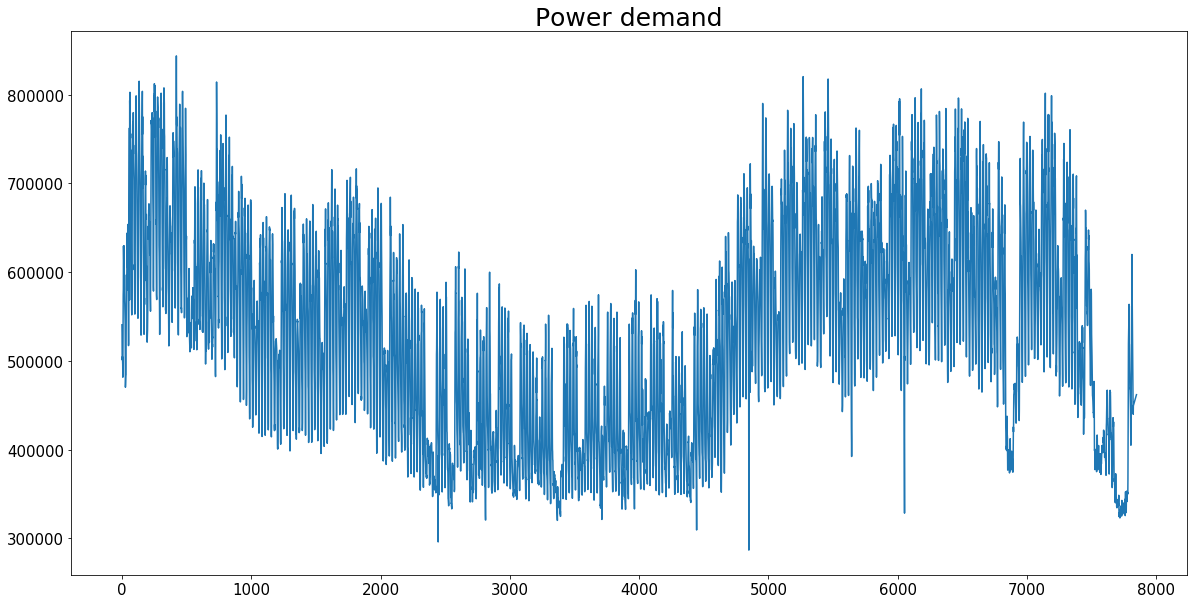

In [9]:
plt.figure(figsize=(20,10))
plt.plot(y)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Power demand',size=25)

(array([ 300000.,  400000.,  500000.,  600000.,  700000.,  800000.,  900000.]),
 <a list of 7 Text yticklabel objects>)

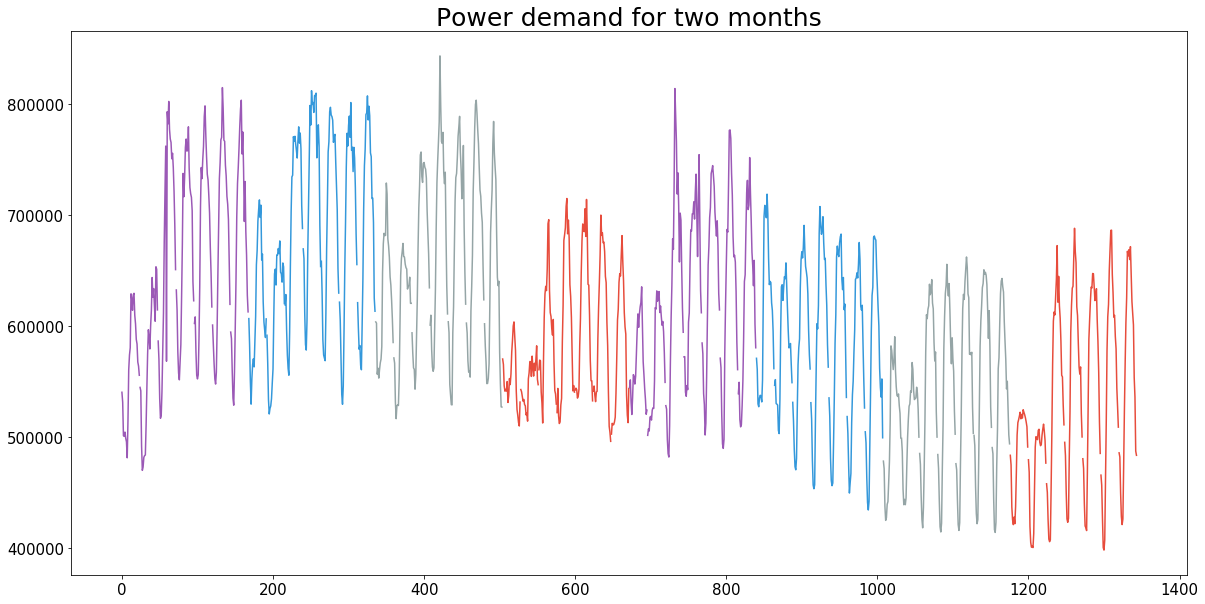

In [20]:
plt.figure(figsize=(20,10))
current_palette = flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for month in range(2):
    for week in range(4):
        for dow in range(7):
            day = month*28+week*7+dow
            plt.plot(y[day*24:day*24+24],current_palette[week])
plt.title('Power demand for two months',size=25)
plt.xticks(size=15)
plt.yticks(size=15)

# Model construction

## Split train and test set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Ordinal Least Square (benchmark) 

In [11]:
# OLS
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
def OLS(X, y):
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R2     = regr.score(X,y)
    return (regr,R2)

In [12]:
(OLS_model,OLS_R2) = OLS(X_train, y_train)

In [13]:
print('R square statistics for OLS model is %f' %OLS_R2)

R square statistics for OLS model is 0.971676


In [14]:
OLS_prediction_raw = OLS_model.predict(X_test)
mse_OLS_raw        = mean_squared_error(OLS_prediction_raw, y_test) 
print("MSE for OLS model is %f" %mse_OLS_raw)
accuracy = mse_OLS_raw**0.5/y_test.mean()
print("Prediction accuracy for OLS model is %f" %(1-accuracy))

MSE for OLS model is 1105524426070244397678592.000000
Prediction accuracy for OLS model is -1976804.951562


MSE for OLS is extremly large and accuracy is unacceptable. We then plot the predictions of power demand in figure below. We can see that prediction for test set has several obvious outliers.

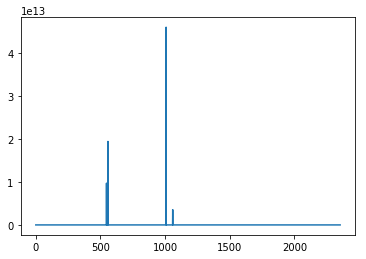

In [15]:
plt.plot(OLS_prediction_raw)

We then manually remove these outlier points from our test dataset and plot the test error again. Note that this method doesn't make any sense as it just tries not to predict the samples that will cause errors without solving the overfitting problem.

In [16]:
OLS_nonOutlier = abs(OLS_model.predict(X_test))<1e7

In [17]:
OLS_prediction_fixed = OLS_model.predict(X_test[OLS_nonOutlier])

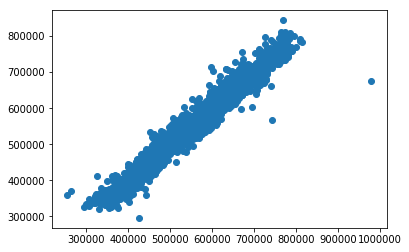

In [18]:
plt.scatter(OLS_prediction_fixed,y_test[OLS_nonOutlier])

In [30]:
mse_OLS_fixed = mean_squared_error(OLS_prediction_fixed, y_test[OLS_nonOutlier]) 
print("MSE for fixed OLS model is %f" %mse_OLS_fixed)
accuracy = mse_OLS_fixed**0.5/y_test[OLS_nonOutlier].mean()
print("Prediction accuracy for fixed OLS model is %f" %(1-accuracy))

MSE for fixed OLS model is 547856250.364775
Prediction accuracy for fixed OLS model is 0.956003


### LASSO and Ridge regression

In [19]:
from sklearn import linear_model
# LASSO
def Lasso(X, y, a, t): 
    clf = linear_model.Lasso(alpha     = a, 
                             tol       = t)
    clf.fit(X, y)
    return clf
#Ridge
def Ridge(X, y, a, t):
    clf = linear_model.Ridge(alpha = a,
                             tol   = True)
    clf.fit(X, y)
    return clf

Text(0,0.5,'Variable coefficients')

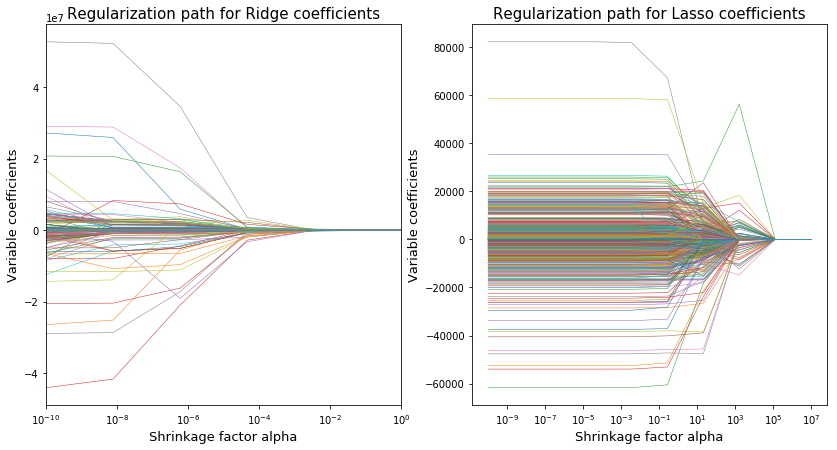

In [21]:
alphas = np.logspace(-10, 7, 10)
coefs_lasso = []
coefs_ridge = []
tol   = 0.001
for a in alphas:
    model_ridge = Ridge(X_train,y_train,a,tol)
    model_lasso = Lasso(X_train,y_train,a,tol)
    coefs_lasso.append(model_lasso.coef_)
    coefs_ridge.append(model_ridge.coef_)
# Plot the regularization path
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,2,1)
ax.set_xscale('log')
ax.set_xlim([1e-10,1e+0])
plt.plot(alphas, coefs_ridge,linewidth=0.5);
plt.title('Regularization path for Ridge coefficients',size=15)
plt.xlabel('Shrinkage factor alpha',size=13)
plt.ylabel('Variable coefficients',size=13)
ax = fig.add_subplot(1,2,2)
ax.set_xscale('log')
plt.plot(alphas, coefs_lasso,linewidth=0.5);
plt.title('Regularization path for Lasso coefficients',size=15)
plt.xlabel('Shrinkage factor alpha',size=13)
plt.ylabel('Variable coefficients',size=13)

In [22]:
# Mannualy choose alpha = 10-4 for ridge and 10+2 for Lasso
model_lasso = Lasso(X_train,y_train,1e+2,tol)
lasso_prediction = model_lasso.predict(X_test)
mse_lasso        = mean_squared_error(lasso_prediction, y_test) 
print("MSE for Lasso model is %f" %mse_lasso)
accuracy = mse_lasso**0.5/y_test.mean()
print("Prediction accuracy for lasso model is %f" %(1-accuracy))

model_ridge = Ridge(X_train,y_train,1e-4,tol)
ridge_prediction = model_ridge.predict(X_test)
mse_ridge        = mean_squared_error(ridge_prediction, y_test) 
print("MSE for Ridge model is %f" %mse_ridge)
accuracy = mse_ridge**0.5/y_test.mean()
numFeatures = np.count_nonzero(model_ridge.coef_)
print("Prediction accuracy for ridge model is %f" %(1-accuracy))

MSE for Lasso model is 579376957.043693
Prediction accuracy for lasso model is 0.954746
MSE for Ridge model is 1284343596.849810
Prediction accuracy for ridge model is 0.932622


Text(0.5,1,'Coefficients for Ridge regression model')

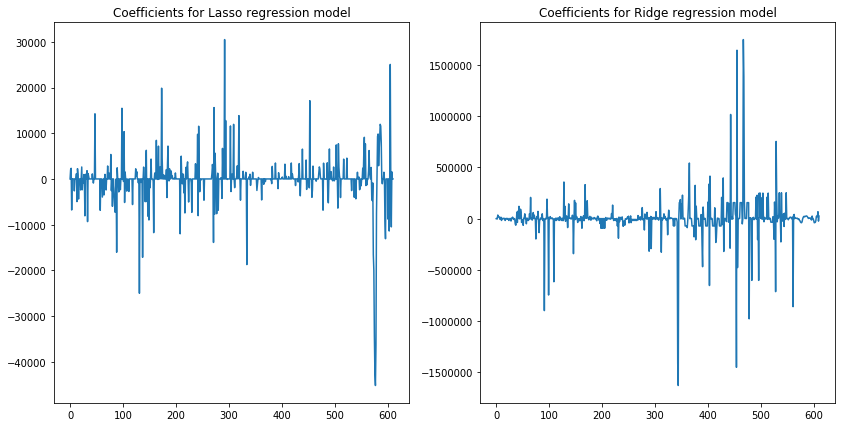

In [23]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,2,1)
ax.plot(model_lasso.coef_)
ax.set_title('Coefficients for Lasso regression model')
ax = fig.add_subplot(1,2,2)
plt.plot(model_ridge.coef_)
ax.set_title('Coefficients for Ridge regression model')

### Subset selection

In [24]:
# Select K best predictor
# Select K-best
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# feature extraction
def kOLS(X, y, n):
    model = SelectKBest(k=n, score_func=f_regression)
    fit = model.fit(X,y)
    features = fit.transform(X)
    OLS_model,OLS_R2 = OLS(features,y)
    return OLS_model,fit,OLS_R2

In [25]:
numFeatures          = 50
(kOLS_model,kFeatures,kOLS_R2) = kOLS(X_train, y_train,numFeatures)

In [26]:
print('R square statistics for KOLS model is %f' %kOLS_R2)

R square statistics for KOLS model is 0.803976


In [27]:
KOLS_prediction = kOLS_model.predict(kFeatures.transform(X_test))
mse_kOLS        = mean_squared_error(KOLS_prediction, y_test) 
print("MSE for kOLS model ("+str(numFeatures)+" features) is %f" %mse_kOLS)
accuracy = mse_kOLS**0.5/y_test.mean()
print("Prediction accuracy for kOLS model is %f" %(1-accuracy))

MSE for kOLS model (50 features) is 2532781618.301672
Prediction accuracy for kOLS model is 0.905381


### Partial least square regression

In [28]:
#PLS
from sklearn.cross_decomposition import PLSRegression
def PLS(X,y,pcNumber):
    pls = PLSRegression(n_components=pcNumber)
    pls.fit(X,y)
    return pls

In [29]:
numComponents = 10
pls_model = PLS(X_train,y_train,10)
pls_prediction = pls_model.predict(X_test)
mse_PLS = mean_squared_error(pls_prediction, y_test)
print("MSE for PLS model is %f" %mse_PLS)
accuracy = mse_PLS**0.5/y_test.mean()
print("Prediction accuracy for PLS model ("+str(numComponents)+" features) "+"is %f" %(1-accuracy))

MSE for PLS model is 846548183.491674
Prediction accuracy for PLS model (10 features) is 0.945298


### Principal components regression

In [30]:
def PCR(X,y,pcNumber):
    pass

## Parameter tuning

In [31]:
def calAccuracy(prediction,test):
    mse = mean_squared_error(prediction, test)
    accuracy = mse**0.5/test.mean()
    return 1-accuracy

Subset n:  1
Subset n:  41
Subset n:  81
Subset n:  121
Subset n:  161
Subset n:  201
Subset n:  241
Subset n:  281
Subset n:  321
Subset n:  361
Ridge: alpha:  0.01
Ridge: alpha:  0.0146779926762
Ridge: alpha:  0.0215443469003
Ridge: alpha:  0.0316227766017
Ridge: alpha:  0.0464158883361
Ridge: alpha:  0.0681292069058
Ridge: alpha:  0.1
Ridge: alpha:  0.146779926762
Ridge: alpha:  0.215443469003
Ridge: alpha:  0.316227766017
Lasso: alpha:  0.01 0.955888960748
Lasso: alpha:  0.0278255940221 0.955893438956
Lasso: alpha:  0.0774263682681 0.955905869969
Lasso: alpha:  0.215443469003 0.955938100596
Lasso: alpha:  0.599484250319 0.95603341661
Lasso: alpha:  1.6681005372 0.956276417703
Lasso: alpha:  4.64158883361 0.956599144515
Lasso: alpha:  12.9154966501 0.956970723687
Lasso: alpha:  35.938136638 0.956251462091
Lasso: alpha:  100.0 0.954527549788
PLS: ncp:  1
PLS: ncp:  12
PLS: ncp:  23
PLS: ncp:  34
PLS: ncp:  45
PLS: ncp:  56
PLS: ncp:  67
PLS: ncp:  78
PLS: ncp:  89
PLS: ncp:  100


<Container object of 3 artists>

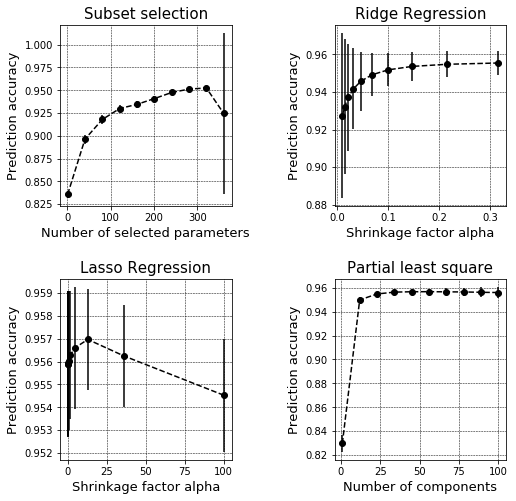

In [47]:
from sklearn.model_selection import KFold
# 10-fold validation
titlesize = 15
labelsize = 13
kf = KFold(n_splits=10,random_state=0)
# Subset selection
accuracy = [ ]
std      = [ ]
Range = list(range(1,400,40))
for n in Range:
    print('Subset n: ',n)
    cvAccuracy = [ ]
    for train,test in kf.split(X_train):
        model,kFeatures,R2 = kOLS(X_train.iloc[train], y_train.iloc[train], n)
        prediction = model.predict(kFeatures.transform(X_train.iloc[test]))
        cvAccuracy.append(calAccuracy(prediction,y_train.iloc[test]))
    accuracy.append(np.mean(cvAccuracy))
    std.append(np.std(cvAccuracy))
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace = 0.6,hspace = 0.4)
ax = fig.add_subplot(2,2,1)
ax.set_title('Subset selection',size=titlesize)
ax.set_xlabel('Number of selected parameters',size = labelsize)
ax.set_ylabel('Prediction accuracy',size = labelsize)
ax.grid(color='black', linestyle='--', linewidth=0.5)
ax.errorbar(np.array(Range), accuracy, yerr=std, fmt='--o',color='black')
# Ridge
accuracy = [ ]
std      = [ ]
Range = np.logspace(-2, -0.5, 10)
for alpha in Range:
    print("Ridge: alpha: ",alpha)
    cvAccuracy = [ ]
    for train,test in kf.split(X_train):
        model = Ridge(X_train.iloc[train], y_train.iloc[train],alpha,1e-4)
        prediction = model.predict(X_train.iloc[test])
        cvAccuracy.append(calAccuracy(prediction,y_train.iloc[test]))
    accuracy.append(np.mean(cvAccuracy))
    std.append(np.std(cvAccuracy))
ax = fig.add_subplot(2,2,2)
ax.set_title('Ridge Regression',size = titlesize)
ax.set_xlabel('Shrinkage factor alpha',size = labelsize)
ax.set_ylabel('Prediction accuracy',size = labelsize)
ax.grid(color='black', linestyle='--', linewidth=0.5)
ax.errorbar(np.array(Range), accuracy, yerr=std, fmt='--o',color='black')
# Lasso
accuracy = [ ]
std      = [ ]
Range = np.logspace(-2, 2, 10)
for alpha in Range:
    cvAccuracy = [ ]
    for train,test in kf.split(X_train):
        model = Lasso(X_train.iloc[train], y_train.iloc[train],alpha,1e-4)
        prediction = model.predict(X_train.iloc[test])
        cvAccuracy.append(calAccuracy(prediction,y_train.iloc[test]))
    print("Lasso: alpha: ",alpha,np.mean(cvAccuracy))
    accuracy.append(np.mean(cvAccuracy))
    std.append(np.std(cvAccuracy))
ax = fig.add_subplot(2,2,3)
ax.set_title('Lasso Regression',size = titlesize)
ax.set_xlabel('Shrinkage factor alpha',size = labelsize)
ax.set_ylabel('Prediction accuracy',size = labelsize)
ax.grid(color='black', linestyle='--', linewidth=0.5)
ax.errorbar(np.array(Range), accuracy, yerr=std, fmt='--o',color='black')
# PLS
accuracy = [ ]
std      = [ ]
Range = np.linspace(1, 100, 10).astype('int')
for ncp in Range:
    print("PLS: ncp: ",ncp)
    cvAccuracy = [ ]
    for train,test in kf.split(X_train):
        model = PLS(X_train.iloc[train], y_train.iloc[train],int(ncp))
        prediction = model.predict(X_train.iloc[test])
        cvAccuracy.append(calAccuracy(prediction,y_train.iloc[test]))
    accuracy.append(np.mean(cvAccuracy))
    std.append(np.std(cvAccuracy))
ax = fig.add_subplot(2,2,4)
ax.set_title('Partial least square',size = titlesize)
ax.set_xlabel('Number of components',size = labelsize)
ax.set_ylabel('Prediction accuracy',size = labelsize)
ax.grid(color='black', linestyle='--', linewidth=0.5)
ax.errorbar(np.array(Range), accuracy, yerr=std, fmt='--o',color='black')

In [48]:
fig.savefig('./2d.png')

## Model comparison

In [61]:
test_accuracy = [ ]
parameter     = [321,12.9,0.316,36]
tol = 1e-4
# Subset
(kOLS_model,kFeatures,kOLS_R2) = kOLS(X_train, y_train,parameter[0])
print('R square statistics for KOLS model is %f' %kOLS_R2)
prediction = kOLS_model.predict(kFeatures.transform(X_test))
mse_kOLS        = mean_squared_error(prediction, y_test) 
print("MSE for Subset model ("+str(numFeatures)+" features) is %f" %mse_kOLS)
test_accuracy.append(calAccuracy(prediction,y_test))
# Lasso
model_lasso = Lasso(X_train,y_train,parameter[1],tol)
prediction = model_lasso.predict(X_test)
test_accuracy.append(calAccuracy(prediction,y_test))
mse_lasso        = mean_squared_error(prediction, y_test) 
print("MSE for Lasso model is %f" %mse_lasso)
# Ridge
model_ridge = Ridge(X_train,y_train,parameter[2],tol)
prediction = model_ridge.predict(X_test)
mse_ridge        = mean_squared_error(prediction, y_test) 
print("MSE for Ridge model is %f" %mse_ridge)
test_accuracy.append(calAccuracy(prediction,y_test))
# PLS
numComponents = parameter[3]
pls_model = PLS(X_train,y_train,numComponents)
prediction = pls_model.predict(X_test)
mse_PLS = mean_squared_error(prediction, y_test)
print("pls-mse"+str(mse_PLS))
test_accuracy.append(calAccuracy(prediction,y_test))
print(test_accuracy)

R square statistics for KOLS model is 0.961883
MSE for Subset model (50 features) is 651303987.899009
MSE for Lasso model is 502923019.457122
MSE for Ridge model is 534375828.194593
pls-mse516755918.407
[0.95201873018374472, 0.95783708529911649, 0.95653864410198863, 0.95726117301486502]


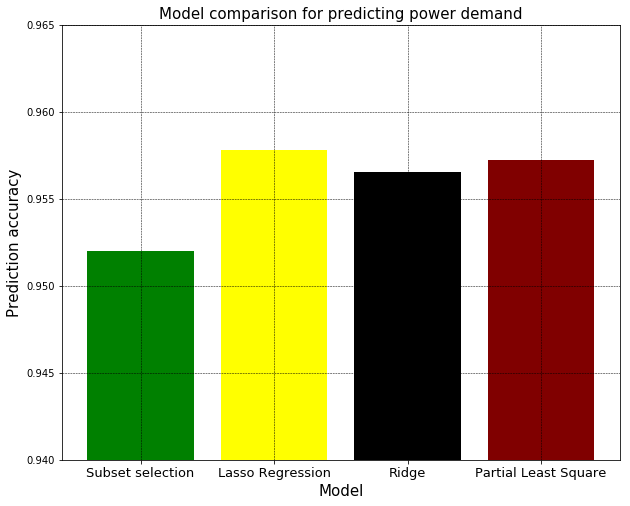

In [62]:
models = np.array(['Subset selection', 'Lasso Regression',
                   'Ridge',            'Partial Least Square'])
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(1,5),test_accuracy, 
        color = ['g', 'yellow', 'k', 'maroon'])
ax.set_xticks(np.arange(1,5))
ax.set_xticklabels(models,size=13)
ax.set_ylim([0.94,0.965])
ax.set_title('Model comparison for predicting power demand',
                size=15)
ax.set_xlabel("Model",size=15)
ax.set_ylabel("Prediction accuracy",size=15)
ax.grid(color='black', linestyle='--', linewidth=0.5)

## Analysis of selected features

### Obtain Lasso and Ridge coefficients 

Predictors with high prediction power contain time-related dummy variables (e.g. hour, month) as well as temperature variables (e.g. water temperature, air handling units value, etc.)

In [63]:
coef_lasso = pd.DataFrame(np.abs(model_lasso.coef_),index=X.columns,columns=['coef'])
#coef_lasso.sort_values(by=['coef'],ascending=False)[:50]
coef_ridge = pd.DataFrame(np.abs(model_ridge.coef_),index=X.columns,columns=['coef'])
#coef_ridge.sort_values(by=['coef'],ascending=False)[:50]

### Comparison of top 50 coefficents

In [64]:
coef_lasso_set = set(coef_lasso.sort_values(by=['coef'],ascending=False)[:50].index)
coef_ridge_set = set(coef_ridge.sort_values(by=['coef'],ascending=False)[:50].index)

#### Intersection of selected variables

In [65]:
coef_lasso_set & coef_ridge_set

{'UC-NAE-3_UC-NAE-3/N2-1.AHU5.MA-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-14.AHU-8_Zones.144SW-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-14.AHU-8_Zones.244NW-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-15.AHU-9_Zones.132-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-21.DCT4-DPR.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.VAV03.ZN-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.VAV04.ZN-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/Programming.Air_Handling_Units.AHU-2.Reset_Schedues.DA-RESET-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/Programming.Hot_Water_System.Reset_Schedues.Hot_Water_Temp.HW-HIGH-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/Programming.Hot_Water_System.Reset_Schedues.Hot_Water_Temp.OA-HIGH-SP.PRESENT_VALUE',
 'hour__13',
 'hour__2',
 'hour__3',
 'hour__4',
 'hour__5',
 'mon__12',
 'mon__5',
 'mon__6',
 'mon__7'}

#### Difference in selected variables

In [66]:
coef_lasso_set ^ coef_ridge_set

{'UC-NAE-3_UC-NAE-3/N2-1.AHU3.MALL-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.AHU5.DA-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.AHU5.RA-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.AHU6.AHU-6.CG-OA-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.AHU6.AHU-6.DAT-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.AHU6.AHU-6.F_B-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.AHU6.AHU-6.PR-LL-DF.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-1.AHU-1.F_B-DIFF.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-1.AHU-1.OA-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-10.AHU-8_Zones.RM141-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-14.AHU-8_Zones.243-SP.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-15.AHU-9_Zones.146D-DPR.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-15.AHU-9_Zones.RM238-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-16.AHU-7_Zones.MZ4_Stpt.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-16.AHU-8_Zones.244SW-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-3/N2-1.EN-16.Entropy.ENTROPY-T.PRESENT_VALUE',
 'UC-NAE-3_UC-NAE-

### 2-D Visualization using selected variables

In [73]:
'''Codes modified from lecture notes of 12-752'''
def lowDimVisualize(F,y,categories):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    colors = sns.cubehelix_palette(categories)
    ySorted = np.sort(y)
    labels = np.zeros((len(y)))
    for i in range(len(y)):
        labels[i] = int(np.min(np.where(ySorted == y[i]))/len(y)*categories)
    labels.astype('int')
    model = TSNE(n_components=2, random_state=0)
    pca = PCA(n_components=2,whiten=True)
    newHar = model.fit_transform(F)
    TSNEF = newHar
    PCAF = pca.fit_transform(F)
    fig = plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    for c in range(categories):
        ix = np.where(labels==c)[0]
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=colors[c])
    plt.title('2D Visulization of TSNE',size=18)
    plt.xlabel('tsne-1',size=15)
    plt.ylabel('tsne-2',size=15)
    plt.subplot(1,2,2)
    for c in range(categories):
        ix = np.where(labels==c)[0]
        plt.scatter(PCAF[ix,0], PCAF[ix,1], color=colors[c])
    plt.title('2D Visulization of PCA',size=18)
    plt.xlabel('Compoment one',size=15)
    plt.ylabel('Component two',size=15)
    fig.savefig('./2dvisu.png')

In [74]:
selectedVars = np.array(list(coef_lasso_set & coef_ridge_set))

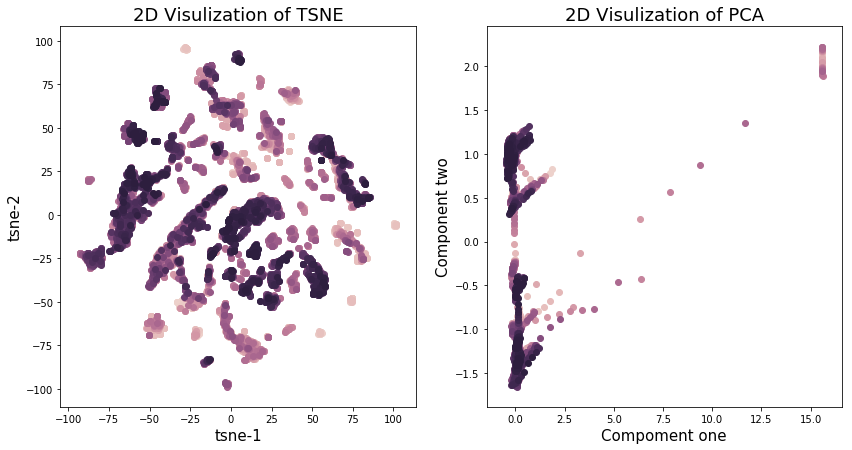

In [75]:
lowDimVisualize(X[selectedVars],y,100)


In [71]:
fig.savefig('./2dvisu.png')